In [55]:
# import PyPDF2
from PIL import Image
from io import BytesIO
import base64
import json
import requests
import cv2
import numpy as np
from collections import OrderedDict
from collections import defaultdict
import os
from subprocess import call
import PyPDF2

# Image Extraction and OCR

## code

In [2]:
def point_to_tuple(box):
    return tuple(OrderedDict(sorted(box.items())).values())

def get_bbox_tuples(detection):
    return map(point_to_tuple, detection['rectangle'])

def draw_detections(pil_image, detections):
    open_cv_image = np.array(pil_image) 
    for box in detections:
        lr, ul = get_bbox_tuples(box)
        cv2.rectangle(open_cv_image, ul, lr, color=(100, 100, 100), thickness=1)
    return Image.fromarray(open_cv_image, 'P')

In [44]:
def extract_pdf_images(pdf_file):
    decrypted_file = decrypt_pdf(pdf_file)
    pdf_doc = PyPDF2.PdfFileReader(open(decrypted_file, "rb"))
    page_range = range(0, pdf_doc.getNumPages())
    for page_n in page_range:
        pdf_page = pdf_doc.getPage(page_n)
        img_to_disp = extract_image_from_page(pdf_page, pdf_name, page_n)

def decrypt_pdf(encrypted_pdf):
    decrypted_filename = 'decryp_' + encrypted_pdf
    call('qpdf --password=%s --decrypt %s %s' %('', encrypted_pdf, decrypted_filename), shell=True)
    return decrypted_filename

def extract_image_from_page(page, pdf_source, page_n, return_image=False):
    
    img_modes = {'/DeviceRGB': 'RGB', '/DefaultRGB': 'RGB',
             '/DeviceCMYK': 'CMYK', '/DefaultCMYK': 'CMYK',
             '/DeviceGray': 'L', '/DefaultGray': 'L',
             '/Indexed': 'P'}
    
    image_name_prefix = 'page_' + str(page_n)
    dest_dir = os.path.join('extracted_images', pdf_source.replace('.pdf', '').replace(' ', '_'))
    dest_path = os.path.join(dest_dir, image_name_prefix)
    os.makedirs(dest_dir, exist_ok=True)
    image_to_return = None
    
    if '/XObject' not in page['/Resources'].keys():
        return
    x_objects = page['/Resources']['/XObject'].getObject()
    count_interpolated = sum(['/Interpolate' in x_objects[obj].keys() for obj in x_objects]) 
    all_interpolated = len(x_objects) == count_interpolated or count_interpolated == 0
    page_images = defaultdict(lambda: defaultdict(list))
    color_space = None
    for obj in x_objects:
        if x_objects[obj]['/Subtype'] == '/Image':
            if '/Interpolate' not in x_objects[obj].keys() and not all_interpolated:
                continue
            size = (x_objects[obj]['/Width'], x_objects[obj]['/Height'])
            try:
                data = x_objects[obj].getData()
            except (NotImplementedError, AssertionError) as e:
                print(e)
                continue
            color_space = x_objects[obj]['/ColorSpace']
            if color_space == '/DeviceRGB':
                mode = "RGB"
            elif isinstance(color_space, PyPDF2.generic.ArrayObject) and color_space[0] == '/Indexed':
                color_space, base, hival, lookup = [v.getObject() for v in color_space] # pg 262
                mode = img_modes[color_space]
            else:
                mode = "P"
            if x_objects[obj]['/Filter'] == '/FlateDecode':
                if isinstance(data, str):
                    continue
                img = Image.frombytes(mode, size, data)
                page_images[mode]['/FlateDecode'].append(img)
            elif x_objects[obj]['/Filter'] == '/DCTDecode':
                img = open(dest_path + ".jpg", "wb")
                img.write(data)
                img.close()
                page_images[mode]['/DCTDecode'].append(img)
                
    for mode, img_filters in page_images.items():
        for img_filt, images in img_filters.items():
            if mode not in ['P', 'RGB'] or img_filt not in ['/FlateDecode']:
                if mode = '/DCTDecode':
                    return
                print(mode, img_filt)
                continue
            if len(images) < 2:
                image_to_return = images[0]
            else:
                widths, heights = zip(*(i.size for i in images))
                total_height = sum(heights)
                max_width = max(widths)
                concat_image = Image.new(mode, (max_width, total_height))
                vert_offset = 0
                for im in images[::-1]:
                    concat_image.paste(im, (0, vert_offset))
                    vert_offset += im.size[1]        
                concat_image.save(dest_path + ".png")
                image_to_return = concat_image
    

    
    if image_to_return:
        if color_space == '/Indexed':
            try:
                image_to_return.putpalette(lookup.getData())
                image_to_return = image_to_return.convert('RGB')
            except (AttributeError, ValueError) as e:
                print(page_n, e)
                return              
        
        image_to_return.save(dest_path + ".png")
        if return_image:
            return image_to_return
    
def query_vision_ocr(image_str, merge_boxes=True, include_merged_components=True, as_json=True, max_pix_size=None):
    api_entry_point = 'http://vision-ocr.dev.allenai.org/v1/ocr'
    header = {'Content-Type': 'application/json'}
    
    request_data = {
        'mergeBoxes': merge_boxes,
        'includeMergedComponents': include_merged_components
    }

    if len(image_str) > 500:
        request_data['image'] = image_str
    else:
        request_data['url'] = image_str
    
    json_data = json.dumps(request_data)
    response = requests.post(api_entry_point, data=json_data, headers=header)
    if response.reason != 'OK':
        print(response.reason)
    json_response = json.loads(response.content.decode())
    if as_json:
        response = json_response
    return response

## run

In [4]:
cd Third_International_MSS/

/Users/schwenk/wrk/z__scratch/pdf_exp/Third_International_MSS


In [48]:
pdfs_to_proc

['1995_TIMSS_4th_Grade_Science_61.pdf',
 '1995_TIMSS_8th_Grade_Science_87.pdf',
 '2003_TIMSS_Science_4th_grade_released_75.pdf',
 '2003_TIMSS_Science_8th_grade_released_95.pdf',
 '2007_TIMSS_4th_Grade_Science_Released_72.pdf',
 '2007_TIMSS_8th_Grade_SCIENCE_released_89.pdf',
 '2011_TIMSS_4th_grade_Science_Release_84.pdf',
 '2011_TIMSS_8th_grade_Science_Release_99.pdf']

In [47]:
pdfs_to_proc = ! ls *pdf

In [49]:
for pdf_name in pdfs_to_proc:
    print(pdf_name)
    extract_pdf_images(pdf_name)

1995_TIMSS_4th_Grade_Science_61.pdf
1995_TIMSS_8th_Grade_Science_87.pdf
2003_TIMSS_Science_4th_grade_released_75.pdf
2003_TIMSS_Science_8th_grade_released_95.pdf
13 'ByteStringObject' object has no attribute 'getData'
2007_TIMSS_4th_Grade_Science_Released_72.pdf
2007_TIMSS_8th_Grade_SCIENCE_released_89.pdf



P /DCTDecode
P /DCTDecode
P /DCTDecode
P /DCTDecode
P /DCTDecode
P /DCTDecode
P /DCTDecode
P /DCTDecode
P /DCTDecode
P /DCTDecode
P /DCTDecode
P /DCTDecode
P /DCTDecode
P /DCTDecode
16 'ByteStringObject' object has no attribute 'getData'
P /DCTDecode
P /DCTDecode
P /DCTDecode
19 'ByteStringObject' object has no attribute 'getData'
P /DCTDecode
P /DCTDecode
P /DCTDecode
P /DCTDecode
P /DCTDecode
24 'ByteStringObject' object has no attribute 'getData'
P /DCTDecode
P /DCTDecode
P /DCTDecode
27 'ByteStringObject' object has no attribute 'getData'
P /DCTDecode
P /DCTDecode
P /DCTDecode
P /DCTDecode
32 'ByteStringObject' object has no attribute 'getData'
P /DCTDecode
33 'ByteStringObjec

## OCR Example

In [52]:
pdf_name = './decryp_2011_TIMSS_4th_grade_Science_Release_84.pdf'
# pdf_name = './decryp_2003_TIMSS_Science_4th_grade_released_75.pdf'

pdf_doc = PyPDF2.PdfFileReader(open(pdf_name, "rb"))
pdf_page = pdf_doc.getPage(70)
img_to_disp = extract_image_from_page(pdf_page, pdf_name, 70, True)

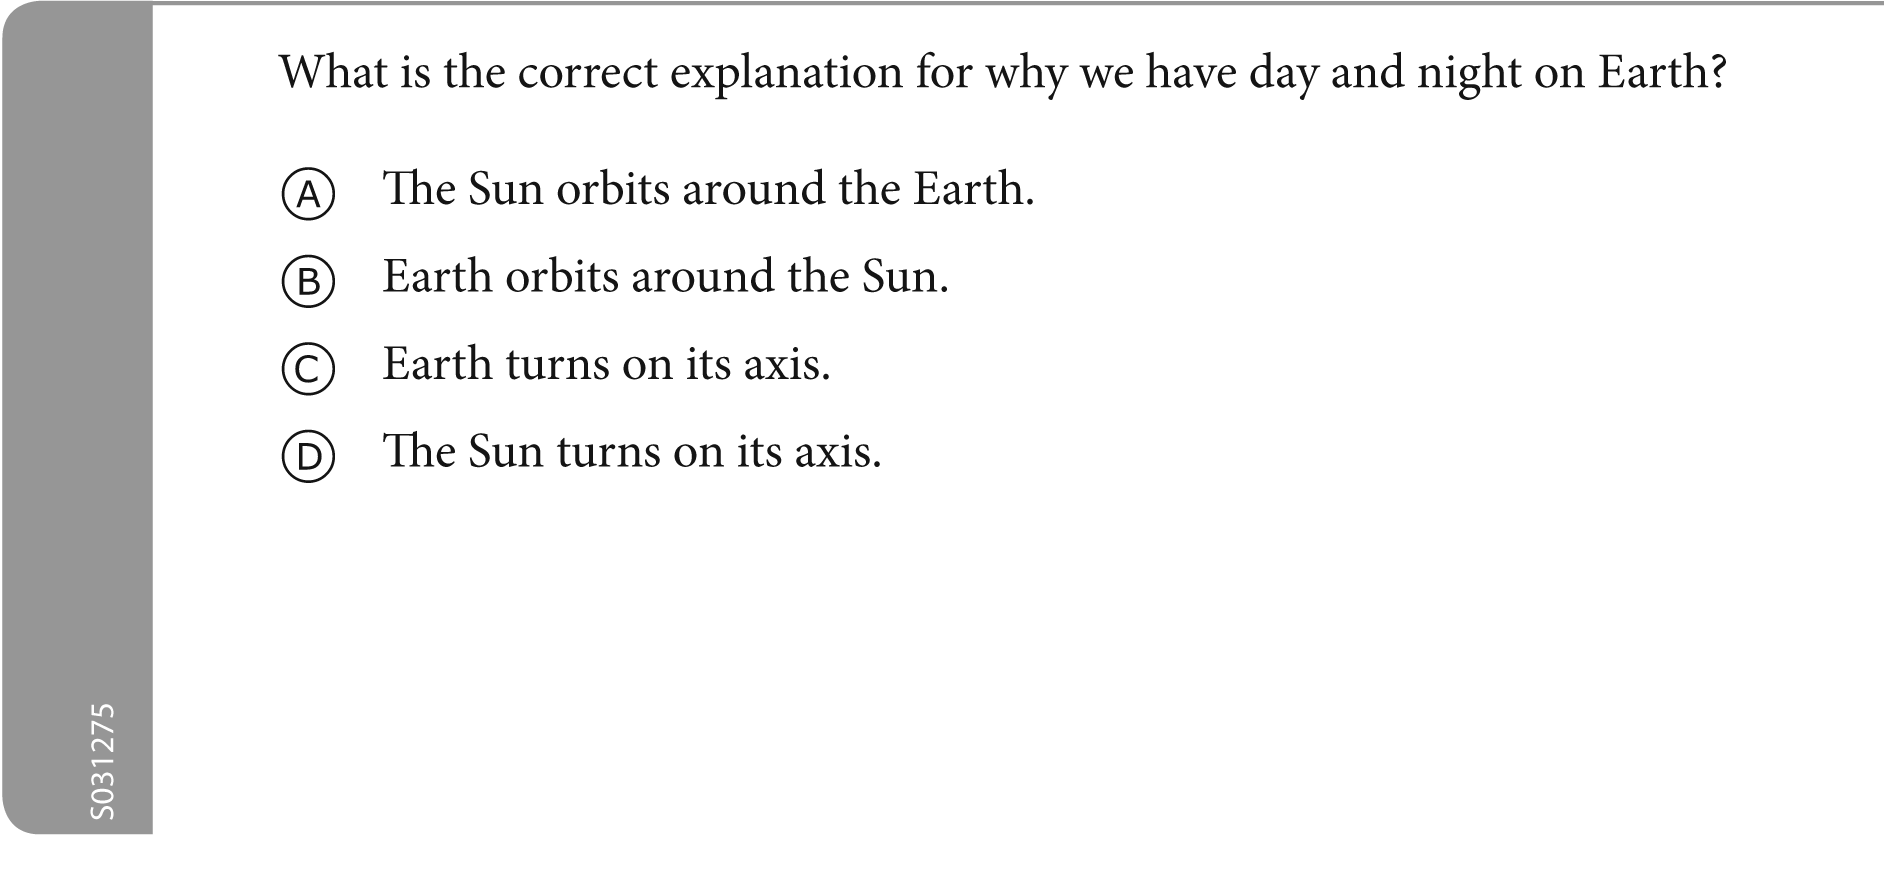

In [53]:
img_to_disp

In [59]:
for detection in response['detections']:
    print(detection['value'])

@
Un
CA
D The
What is the correct explanation for why we have day and night on Earth?
CA The Sun orbits around the Earth.
B
Earth orbits around the Sun
C)
Earth turns on its axis.
D The Sun turns on its axis.


In [57]:
sbuffer = BytesIO()
img_to_disp.save(sbuffer, format="PNG")
b64_image = base64.b64encode(sbuffer.getvalue())
str_image = b64_image.decode()

In [58]:
response = query_vision_ocr(str_image, merge_boxes=False, include_merged_components=False)

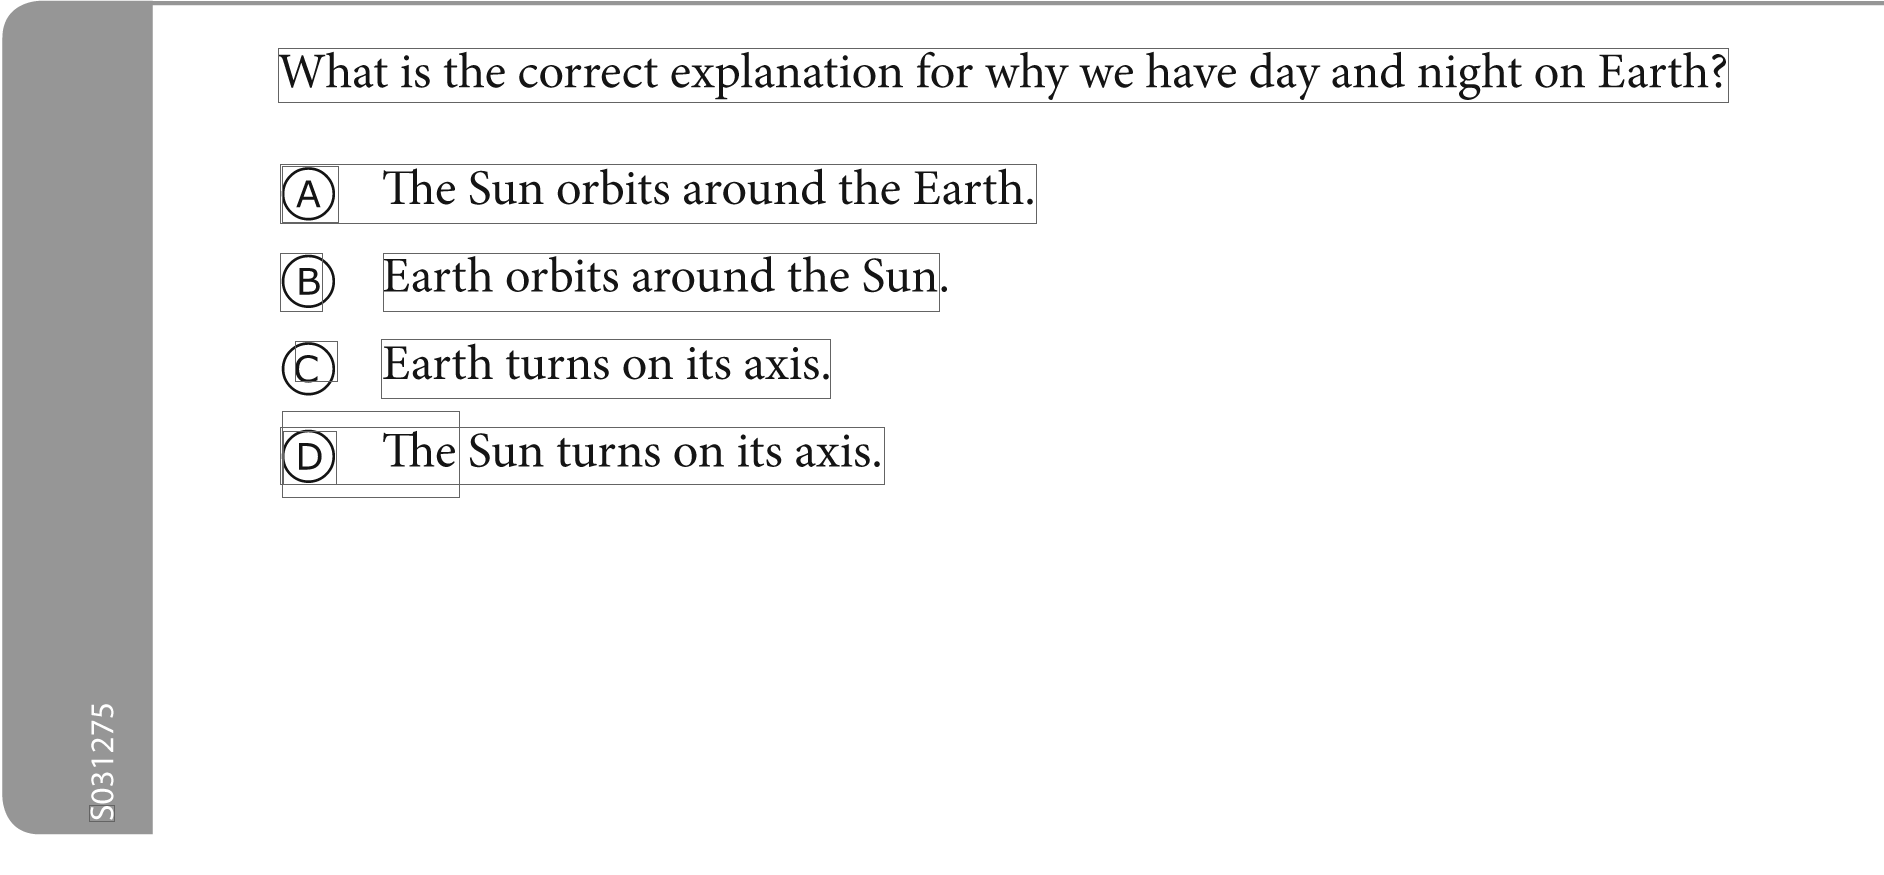

In [60]:
draw_detections(img_to_disp, response['detections'])